<a href="https://colab.research.google.com/github/kojiyam/information-transmission-engineering/blob/main/jd1_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 可聴帯域搬送波のQPSK変調信号

式番号は守倉他『通信方式』

実行: Shift+Enter

In [1]:
import numpy as np
np.random.seed(1) # 乱数のseedは固定

import matplotlib.pyplot as plt
#plt.style.use('dark_background') # for dark-mode
plt.rcParams["font.size"] = 16
from matplotlib import animation
import IPython.display

## 単純な正弦波（搬送波）を鳴らす方法

In [2]:
# 搬送波のパラメータ
Ac = 0.6
fc = 523 # (Hz) Carrier frequency
sampling_rate = 10000 # (Hz) 音として出力するためのサンプリング周波数．変調とは関係なし

$ \mathrm{Re} [ A_\mathrm{c} \mathrm{e}^{\mathrm{j} 2\pi f_\mathrm{c} t} ] = A_\mathrm{c} \cos (2\pi f_\mathrm{c} t)$

In [3]:
T_LENGTH = 10 # 音の時間長 (s)
t = np.arange( T_LENGTH * sampling_rate ) / sampling_rate # サンプリング時刻
# s = np.real( Ac * np.exp( (1j) * 2 * np.pi * fc * t) )
s = Ac * np.cos( 2 * np.pi * fc * t ) # これでも同じ

In [4]:
t

array([0.0000e+00, 1.0000e-04, 2.0000e-04, ..., 9.9997e+00, 9.9998e+00,
       9.9999e+00])

sampling_rate = 10 kHz であれば，サンプリング間隔は100 μs = 10$^{-4}$ s

In [5]:
IPython.display.Audio(s, rate = sampling_rate)

In [6]:
f1 = 523
f2 = 525
# s = (1/2) * ( Ac * np.cos( 2 * np.pi * f1 * t) + Ac * np.cos( 2 * np.pi * f2 * t) )
s = Ac * np.cos( 2 * np.pi * fc * t) * np.cos( 2* np.pi * 1* t)

IPython.display.Audio(s, rate = sampling_rate)

位相を見せたいが，手つかず

it1_modulationでできていた

## 変調

`Ts` は，(12.1)などではシンボル長 $T$

In [7]:
N = 10  # Number of symbols
Ts = 1 # Symbol length (s/symbol)

#N = 100  # Number of symbols
#Ts = 0.1 # Symbol length (s/symbol)


`B` は (12.9) $ (b_{nM},b_{nM+1},\dots,b_{(n+1)M-1} ) $

$M$ は1シンボルあたりのビット数．ここではQPSKのため，$M=2$



In [8]:
B = np.random.randint(0, 4, N) # 2 bitを表す [0,3] の一様乱数N個．ビット系列 bit sequence

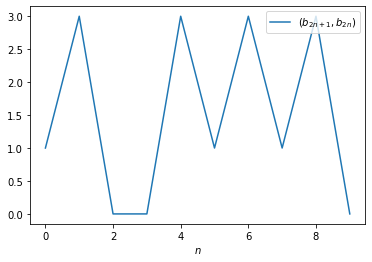

In [9]:
plt.plot(B, label='$(b_{2n+1},b_{2n})$')
plt.xlabel('$n$')
plt.legend(loc='upper right')

縦軸は $ B_n := 2 b_{n+1} + b_{2n} $

例えば，縦軸が2であれば $(b_{2n+1},b_{2n})=(1,0)$


`A` は (12.9) に関連して，$ a_n = \exp(\mathrm{j} \pi (1+2 B_n)/4)$

In [10]:
A = np.exp(1j * (1/4 + B/2) * np.pi) # QPSK

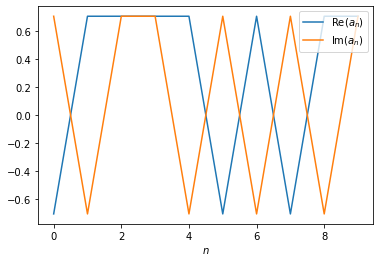

In [11]:
plt.plot(A.real, label='$\mathrm{Re}(a_n)$')
plt.plot(A.imag, label='$\mathrm{Im}(a_n)$')
plt.xlabel('$n$')
plt.legend(loc='upper right')

(離散時間)系列から，(連続時間)信号に

In [12]:
# Rectangular pulse filter
# b = np.repeat(sQ,Ts*Fs)

(12.10) $ \displaystyle x(t) = \sum_{n=-\infty}^\infty a_n \, \delta(t-nT) $

(12.12) $ \delta(t) = \begin{cases} 1, & 0 \leq t < T \\ 0, & \text{otherwise} \end{cases}$

$\delta(t)$は，デルタ関数ではない

ここでは上記の代わりに，ルート2乗余弦フィルタ（Root raised cosine filter, 『通信方式』11.5節 ）を使う

まず，インパルス系列を作り，その後でルート2乗余弦フィルタのインパルス応答とたたみ込む．

インパルス系列は，(12.10)の $\delta(t)$ として，デルタ関数を用いたものに相当する．ただし，サンプリングしているので，以下のようにした(12.10)の $x(t)$ を $x_0(t)$ としている．

$ \delta(t) = \begin{cases} 1, & t=0 \\ 0, & \text{otherwise} \end{cases}$

In [13]:
# x0はA[0], 0, ..., 0, A[1], 0, ..., 0, A[2] という系列
x0 = np.ravel( np.concatenate([np.reshape(A,(N,1)), 
                              np.zeros([N,sampling_rate*Ts-1]) ], axis=1) )
t = np.arange(N*sampling_rate)/sampling_rate

In [14]:
# x0は以下でも作ることができる
# x0 = np.empty(0)
# for i in range(N):
#    x0 = np.concatenate([x, np.atleast_1d(A[i]), np.zeros(sampling_rate*Ts-1)])

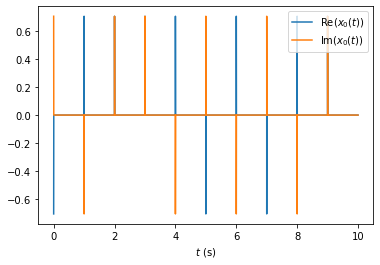

In [15]:
plt.plot(t, x0.real, label='$ \mathrm{Re} (x_0(t)) $')
plt.plot(t, x0.imag, label='$ \mathrm{Im} (x_0(t)) $')
plt.xlabel('$t$ (s)')
plt.legend(loc='upper right')

横軸は時間に変わっていることに注意

『通信方式』11.5節 ルート2乗余弦フィルタ（Root raised cosine filter） 

In [16]:
## Root raised cosine filter のためのライブラリ
## https://commpy.readthedocs.io/en/latest/generated/commpy.filters.rrcosfilter.html
!pip install scikit-commpy
from commpy.filters import rrcosfilter

In [17]:
# フィルタのインパルス応答を生成
# ここでは，前後6シンボル分の波形に限定（パルステイル打ち切り．p.111）
# ロールオフファクタ alpha=0.8
t0, h_RRC = rrcosfilter(Ts*sampling_rate*6, 0.8, Ts, sampling_rate)

Text(0, 0.5, '$ h_\\mathrm{RRC}(t)$')

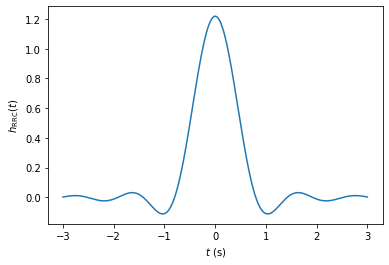

In [18]:
plt.plot(t0,h_RRC)
plt.xlabel('$t$ (s)')
plt.ylabel('$ h_\mathrm{RRC}(t)$')

フィルタの前後分時間が増えるので，`t` とは別に `t2` を作る

以下の `x` が，(12.10) でルート2乗余弦フィルタを適用した場合の $x(t)$

In [19]:
# ベースバンド信号
x = np.convolve(h_RRC, x0) # Waveform with PSF
t2 = np.arange(x.size)/sampling_rate

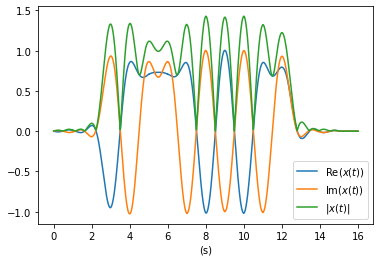

In [20]:
plt.plot(t2, x.real, label='$\mathrm{Re}(x(t))$')
plt.plot(t2, x.imag, label='$\mathrm{Im}(x(t))$')
plt.plot(t2, np.abs(x), label='$|x(t)|$')
plt.xlabel('(s)')
plt.legend(loc='lower right')

https://stackoverflow.com/questions/14614966/easy-way-to-implement-a-root-raised-cosine-rrc-filter-using-python-numpy

In [21]:
Z = 1000 # 動画のための間引き
x.size, int(x.size/Z)

(159999, 159)

$ x(t) $ の複素平面上での様子

In [22]:
# 動画のインターバル．fpsの逆数
#INTERVAL = 50 # (ms) 50 ms だと20 fps
INTERVAL = int(1000*Z/sampling_rate)

In [23]:
fig, ax = plt.subplots()
plt.close()
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((-1.5, 1.5))
ax.set_yticks(np.arange(-1, 1 + 1, 1))
ax.set_aspect('equal')
#line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=5)
def animate(i):
  line2.set_data(x.real[i*Z:i*Z+Z], x.imag[i*Z:i*Z+Z])
anim = animation.FuncAnimation(fig, animate, frames=150, interval=INTERVAL, blit=False)
IPython.display.HTML(anim.to_jshtml())

In [24]:
# 搬送波のパラメータ
Ac = 0.6
fc = 523 # (Hz) Carrier frequency

(12.11) $ s(t) = \mathrm{Re} [ A_\mathrm{c} \mathrm{e}^{\mathrm{j} 2\pi f_\mathrm{c} t} x(t) ] $

In [25]:
s = np.real( Ac * np.exp( (1j) * 2 * np.pi * fc * t2) * x )

In [26]:
IPython.display.Audio(s, rate = sampling_rate)

Text(0, 0.5, '$s(t)$')

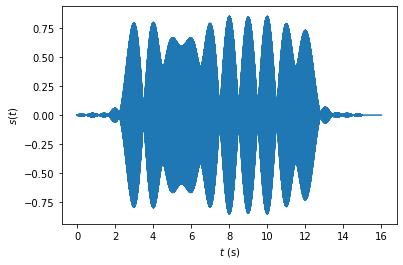

In [27]:
plt.plot(t2, s)
plt.xlabel('$t$ (s)')
plt.ylabel('$s(t)$')

Text(0, 0.5, '$s(t)$')

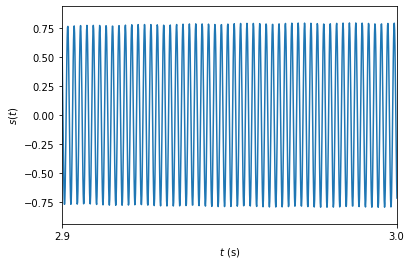

In [28]:
plt.plot(t2, s)
plt.xlim(2.9,3)
plt.xticks(np.arange(2.9, 3.0, 0.1))
plt.xlabel('$t$ (s)')
plt.ylabel('$s(t)$')

## フーリエ変換

In [29]:
S = np.fft.fft(s)

In [30]:
freq = np.fft.fftfreq(s.size, d=1/sampling_rate)

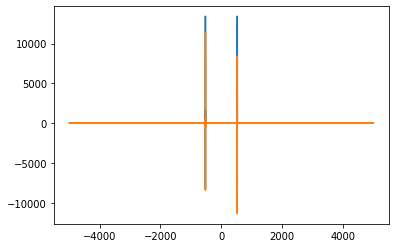

In [31]:
plt.plot(freq, S.real)
plt.plot(freq, S.imag)

In [32]:
S_amp = np.abs(S/(S.size/2))

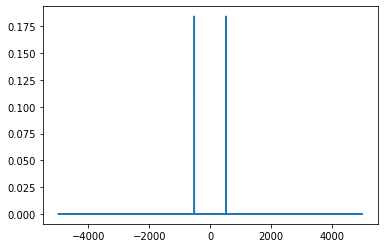

In [33]:
plt.plot(freq, S_amp)

Text(0.5, 0, '$f$ (Hz)')

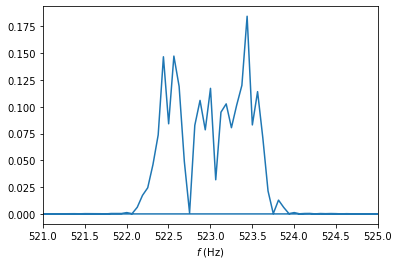

In [34]:
plt.plot(freq, S_amp)
plt.xlim(521,525)
plt.xlabel('$f$ (Hz)')

## ベースバンド信号のスペクトラム

Text(0.5, 0, '$f$ (Hz)')

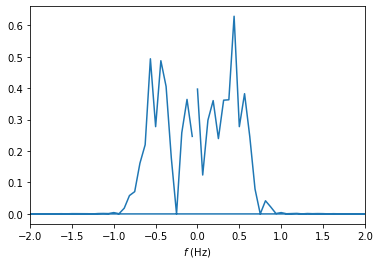

In [35]:
X = np.fft.fft(x)
freq2 = np.fft.fftfreq(x.size, d=1/sampling_rate)
plt.plot(freq2, np.abs(X/(X.size/2)))
plt.xlim(-2,2)
plt.xlabel('$f$ (Hz)')

FFT 参考

https://helve-python.hatenablog.jp/entry/2018/06/17/000000